<a href="https://colab.research.google.com/github/Farhadi71/SPML-CNN/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks
I this notebook, you'll get familiar with the implementation of CNNs by building and training two CNN networks.

## Preparing the Data
For this taks, you're going to use the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. CIFAR10 is a collection of 32 * 32 images in 10 classes. Each image in CIFAR10 has three channels (RGB). You are going to download and prepare the dataset manually.

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision.datasets.utils import download_url
from sklearn.model_selection import train_test_split
from torchvision.io import read_image

**For this question, it's highly recommended to use a CUDA-enabled environment.**
We'll check for the availability of GPU and set `device` accordingly.

In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

In [ ]:
url = "http://dl.dropboxusercontent.com/s/dywydpafhaamquw/cifar10.zip"
# Download the dataset using Torchvision's  `download_url`
#############################
# Your code goes here (1 point)
root = './'
download_url(url, root)
#############################
!unzip -qq "./cifar10.zip"

100%|██████████| 145997066/145997066 [00:02<00:00, 56272781.74it/s]


Now you are going to implement a custom dataset class for the data you've downloaded. You can implement a custom dataset by inheriting from PyTorch's `Dataset` class. You'll then have to override `__init__`, `__len__`, and `__getitem__` functinos in your custom class. One of the advantages of defining a custom dataset like this is that you have complete control over the data that the dataset returns.

The the dataset you've downloaded has the following structure:
```
cifar10/
    test/
        img_file1.png
        img_file2.png
        ..
        ..
        annotation.csv
    train/
        img_file1.png
        img_file2.png
        ...
        ...
        annotation.csv
```

The `annotation.csv` file in each directory contains a complete list of file names and labels for all the image files in that directory. **Keep in mind that the csv files provided have no header information**.

In [ ]:
class CustomCifarDataset():
    def __init__(self, annotations_file, root_dir, transform=None):
        """
        `annotation_file`: Path to the csv file with annotations.
        `root_dir`: Directory with all the images.
        `transform`: Transform to be applied.
        """
        self.root_dir = root_dir
        self.transform = transform
        # Read the csv annotation file using pandas' `read_csv` function.
        # (The annotation file consists of n rows. Each row is in the format 
        #    img_file_name, img_label
        #  For example:
        #    airplane_1001, 0
        # )
        #############################
        # Your code goes here (2 points)
        self.df = pd.read_csv(annotations_file, header=None)
        #############################

    def __len__(self):
        # Return the number of data points
        #############################
        # Your code goes here (1 point)
        #dfLength = self.df.count() --> pandas function
        dfLength = len(self.df)
        return dfLength
        #############################

    def __getitem__(self, idx):
        """
        idx: index of the data point referenced.
        """
        # Use `idx` to index the annotation file you parsed in `__init__`.
        # Using `read_image`, load the corresponding image from the disk.
        # Normalize the data to be between 0 and 1.
        # Apply transformation(s) to the image and return the transformed 
        # image and its label.
        #############################
        # Your code goes here (7 points)
        if torch.is_tensor(idx):
          idx = idx.tolist()

        imageLabel = self.df.iloc[idx, 1]
        imagePath = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        readImage = read_image(imagePath)
        tensorMax = readImage.max()
        tensorMin = readImage.min()
        dataNormalized = (readImage - tensorMin)/(tensorMax - tensorMin)
        imageTransform = {'Image': dataNormalized, 'Label': imageLabel}
        if self.transform:
            imageTransform = self.transform(imageTransform)

        return imageTransform

        #############################

In [ ]:
test_set = CustomCifarDataset("./cifar10/test/annotation.csv", "./cifar10/test/")
train_set = CustomCifarDataset("./cifar10/train/annotation.csv", "./cifar10/train/")

In [ ]:
# Split your training set into train and validation sets (8:2 ratio).
#############################
# Your code goes here (2 points)
train_set , val_set = train_test_split(train_set, test_size=0.2)
#############################

len(train_set), len(val_set), len(test_set)

(40000, 10000, 10000)

In [ ]:
# Construct three `DataLoader`s for validation, training, and test sets.
# Use a batch size of 128.
# No shuffling.
#############################
# Your code goes here (5 points)
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size = 128, shuffle=False)
test_loader = DataLoader(test_set, batch_size = 128, shuffle=False)
val_loader = DataLoader(val_set, batch_size = 128, shuffle=False)

#############################

In [ ]:
def train(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    model.train()
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for train_loaders in train_loader:
            # Compute model's ouptut
            # Move your data to GPU if it's available
            ##############################
            # Your code goes here (5 points)
            xTrain = train_loaders['Image'].to(device)
            yTrain = train_loaders['Label'].to(device)

            yHat = model.forward(xTrain)
            ##############################

            # Compute the loss.
            # Also, use L2 regularization to compute the total loss: `loss + lambda * l2`
            # Set the lambda to 0.001.
            ##############################
            # Your code goes here (7 points)
            loss = loss_fn(yHat, yTrain)
            learningRate = 0.001
            normL2 = sum(torch.norm(w) for w in model.parameters())
            loss = loss + learningRate * normL2

            optimizer.zero_grad()
            ##############################

            # Do the backprop step.
            ##############################
            # Your code goes here (2 points)
            loss.backward()
            optimizer.step()
            ##############################
            
            loss_train += loss.item()

        validation_loss = validate(model, val_loader, loss_fn)
        print('Epoch {}, Training loss {}, Validation loss {}'.format(epoch, loss_train / len(train_loader), validation_loss))


In [ ]:
def validate(model, val_loader, loss_fn):
        with torch.no_grad():
            val_loss = 0.0
            for val_loaders in val_loader:
                # Compute the loss
                ##############################
                # Your code goes here (9 points)
                xVal = val_loaders['Image'].to(device)
                yVal = val_loaders['Label'].to(device)
                
                yHat = model.forward(xVal)
                loss = loss_fn(yHat, yVal)
                learningRate = 0.001
                normL2 = sum(torch.norm(w) for w in model.parameters())
                loss = loss + learningRate * normL2
                ##############################
                val_loss += loss.item()

        return val_loss / len(val_loader)

**Answer the following questions (5 points):**
- What is `torch.no_grad()` and when is it used?

    *Your answer goes here*
    
    


Context-manager that disabled gradient calculation.
Disabling gradient calculation is useful for inference, when you are sure
that you will not call `Tensor.backward()`. It will reduce memory
consumption for computations that would otherwise have `requires_grad=True`.

Take look at this example:
```
x = torch.arange(4., requires_grad=True)
print(x)
y = x * x
z = y + 0.0
print(z.requires_grad)

dd = z * x
dd.sum().backward()
print(x.grad)
```
Output is: $$(3 * x_{t}^3)$$
```
tensor([0., 1., 2., 3.], requires_grad=True)
True
tensor([ 0.,  3., 12., 27.])
```

But with `torch.no_grad()` we have:
```
x = torch.arange(4., requires_grad=True)
print(x)
y = x * x
with torch.no_grad():
  z = y + 0.0
print(z.requires_grad)

dd = z * x
dd.sum().backward()
print(x.grad)
```
And output is: $$( z_{t})$$

```
tensor([0., 1., 2., 3.], requires_grad=True)
False
tensor([0., 1., 4., 9.])
```
In this mode, the result of every computation will have
`requires_grad=False`, even when the inputs have `requires_grad=True`.
This context manager is thread local; it will not affect computation.

To use the functions, you can do the following:
```
>>> @torch.no_grad()
... def doubler(x):
...     return x * 2
>>> z = doubler(x)
>>> z.requires_grad
False
```



- What do the instructions `model.eval()` and `model.train()` do?

    *Your answer goes here*
`model.train()`sets the modules in the network in training mode and model keeps some layers, like dropout, batch-normalization but when we use `model.eval()`, we tell our model set dropout and batch normalization layers to evaluation mode before running inference.

In [ ]:
def test(model, test_loader):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for test_loaders in test_loader:
      # Compute the predicted class and update 
      # `total` and `correct` accordingly
      ##############################  
      # Your code goes here (9 points)
      xTest = test_loaders['Image'].to(device)
      yTest = test_loaders['Label'].to(device)

      yHat = torch.argmax(model.forward(xTest), dim=1)
      y = sum(yHat == yTest).item()

      correct += y
      total += len(xTest)
      ##############################

    return correct / total

## Creating the Model
Now you're going to build the CNN model. The overall architecture of the model you are going to implement is depicted in the following picture (All of the max poolings used have a stride of 2*2):

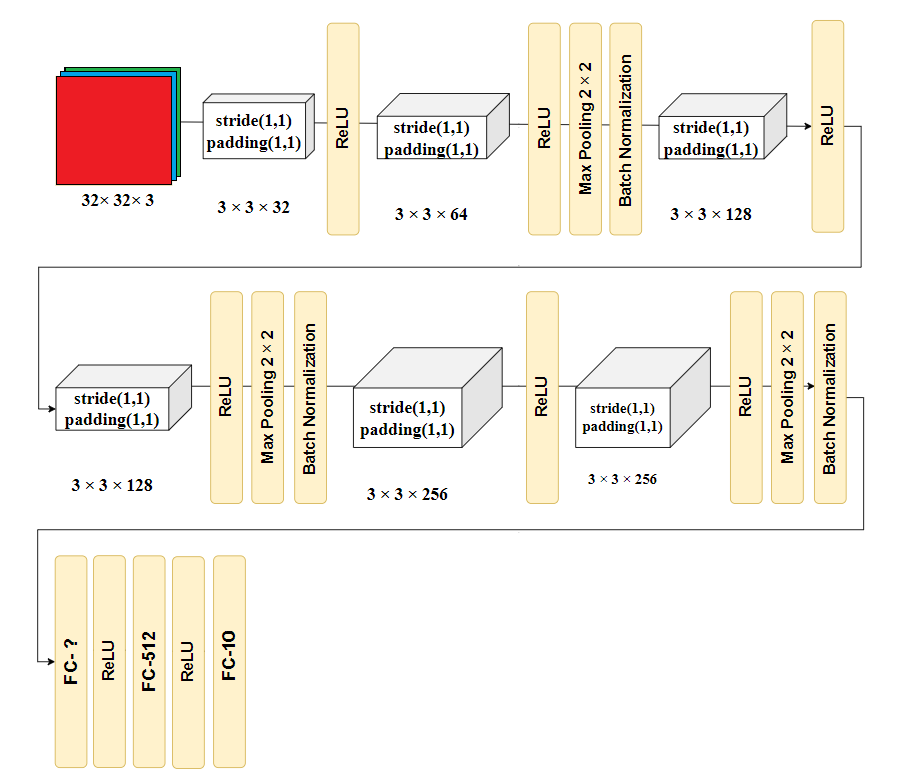

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, out_dim):
        """
        `in_channels`: Number of channels for input instances
        `out_dim`    : The network's output dimensions
        """
        super().__init__()
        self.relu = nn.ReLU()            # Apply for all the layers (except the last one)
        self.maxpool = nn.MaxPool2d(2,2) # Apply for conv2, conv4, and conv6
        
        self.bn1 = nn.BatchNorm2d(64) # Apply for conv2
        self.bn2 = nn.BatchNorm2d(128) # Apply for conv4
        self.bn3 = nn.BatchNorm2d(256) # Apply for conv6
        
        self.conv1 = self.conv2 = self.conv3 = self.conv4 = self.conv5 = self.conv6 = None
        self.fc1 = self.fc2 = self.fc3 = None

        
        # Create five 2D convolutional layers (conv1 through conv6)
        # Set the padding and stride to 1 for all the layers.
        # Use 3*3 kernels.
        ##############################
        # Your code goes here (10 points)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1)

        ##############################

        self.flatten = nn.Flatten()
        
        # According to the output dimensions of `conv6` and the `in_features` value for fc2,
        # set `in_features` and `out_features` for fc1 to proper values. 
        ##############################
        # your code goes here (5 points)
        self.fc1 = nn.Linear(4096, 1024)
        #############################
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, out_dim)
        
    def forward(self, x):
        # Move x thorugh the network and return the output
        # according to the architecture.
        ##############################
        # Your code goes here (10 points)
        x = self.conv1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.bn1(x)

        x = self.conv3(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.bn2(x)

        x = self.conv5(x)
        x = self.relu(x)

        x = self.conv6(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.bn3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        out = x
        ##############################
        return out

In [ ]:
model = SimpleCNN(3, 10).to(device=device)

In [ ]:
# Use Adam optimizer with a learning rate of 0.001 as the optimizer.
# Use CrossEntropy as loss function.
##############################
# Your code goes here (5 points)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
loss_fn = torch.nn.CrossEntropyLoss()
##############################
train(
    n_epochs = 10,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader=val_loader
)

Epoch 1, Training loss 1.2789202374391282, Validation loss 0.9507340751116788
Epoch 2, Training loss 0.8389680972114538, Validation loss 0.8624451017077965
Epoch 3, Training loss 0.648943266929529, Validation loss 0.8751168364210974
Epoch 4, Training loss 0.5238356089439636, Validation loss 0.9520370409458498
Epoch 5, Training loss 0.4323978481201318, Validation loss 1.0267341627350337
Epoch 6, Training loss 0.3695422935600098, Validation loss 1.1088842628877373
Epoch 7, Training loss 0.3432079810684862, Validation loss 1.1007688445380972
Epoch 8, Training loss 0.32073106771459975, Validation loss 1.2209786667099483
Epoch 9, Training loss 0.32278892616875254, Validation loss 1.168736432172075
Epoch 10, Training loss 0.31167525119674855, Validation loss 1.2936504588851445


In [ ]:
test(model, test_loader)

0.7898

## Visualizing Feature Maps

The feature maps, also known as activation maps, record what happens when the filters are applied to an input.


In this section, you're going to visualize feature maps for a random input image for layers `conv1` through `conv6`. 

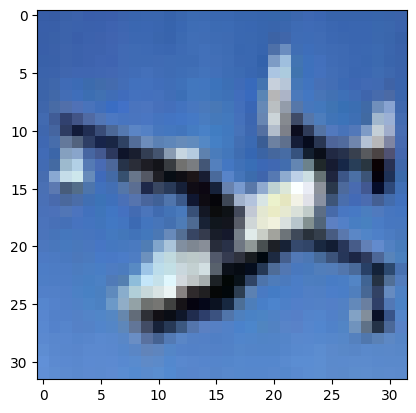

In [ ]:
import random
img = train_set[random.randint(0, len(train_set))]['Image']
plt.imshow(img.permute(1,2,0))
plt.show()

In [ ]:
conv_layers = [model.conv1, model.conv2, model.conv3, model.conv4, model.conv5, model.conv6]

# Pass `img` thorough the layers and save the results for each layer in `output`.
##############################
# Your code goes here (5 points)
outputs = []
names = []
image = img.to(device)
for layer in conv_layers:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
##############################
len(outputs)

6

the first 16 filters of layer 0 : Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


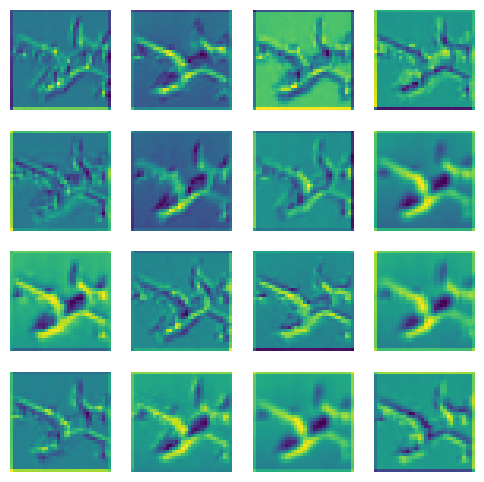

the first 16 filters of layer 1 : Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


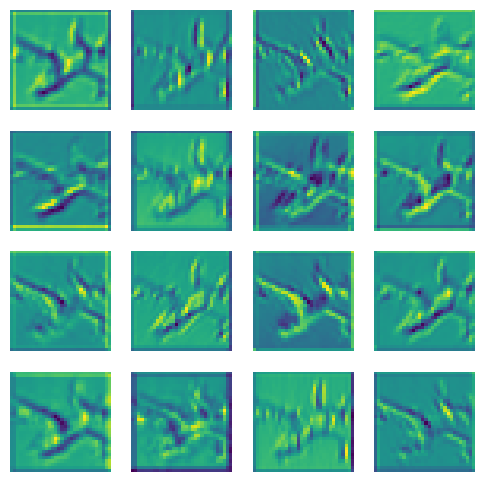

the first 16 filters of layer 2 : Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


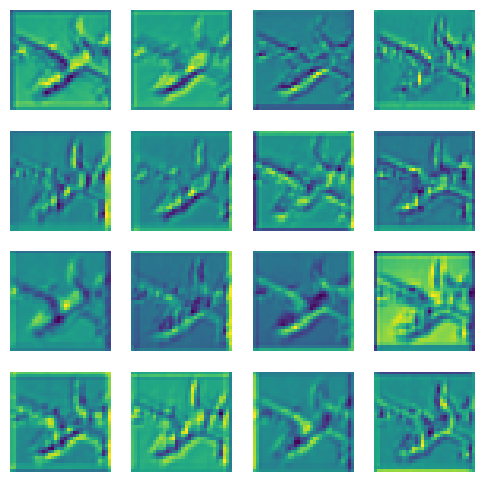

the first 16 filters of layer 3 : Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


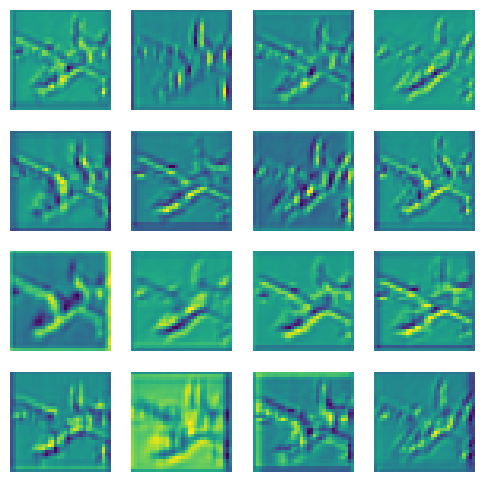

the first 16 filters of layer 4 : Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


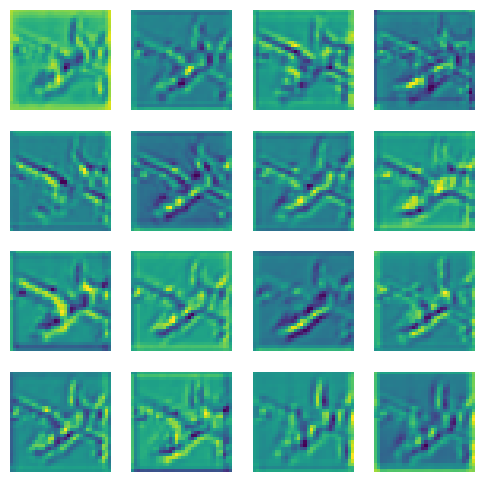

the first 16 filters of layer 5 : Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


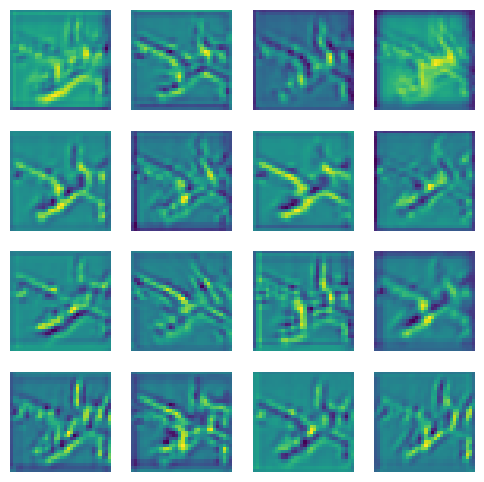

In [ ]:
# Visualize the output for the first 16 filters of each layer.
##############################
# Your code goes here (5 points)

for num in range(len(outputs)):
  print(f"the first 16 filters of layer {num} : {conv_layers[num]}")
  plt.figure(figsize=(6, 6))
  for i in range(16):
    plt.subplot(4, 4, i+1) 
    plt.imshow(outputs[num][:][:][:][i].detach().cpu().numpy(), cmap='viridis')
    plt.axis('off')
  plt.show()


**Answer the following question (5 points):**
- Which one of the feature maps you visualized do you find helpful for the task? Which ones you don't find helpful?

In the early feature maps, the image can be recognized with higher accuracy, this increases the possibility of overfitting, in the following, the accuracy of the image decreases, and things such as edges, contrast, and the overall shape of the image are seen as distinguishable features, which It is very suitable for this task.




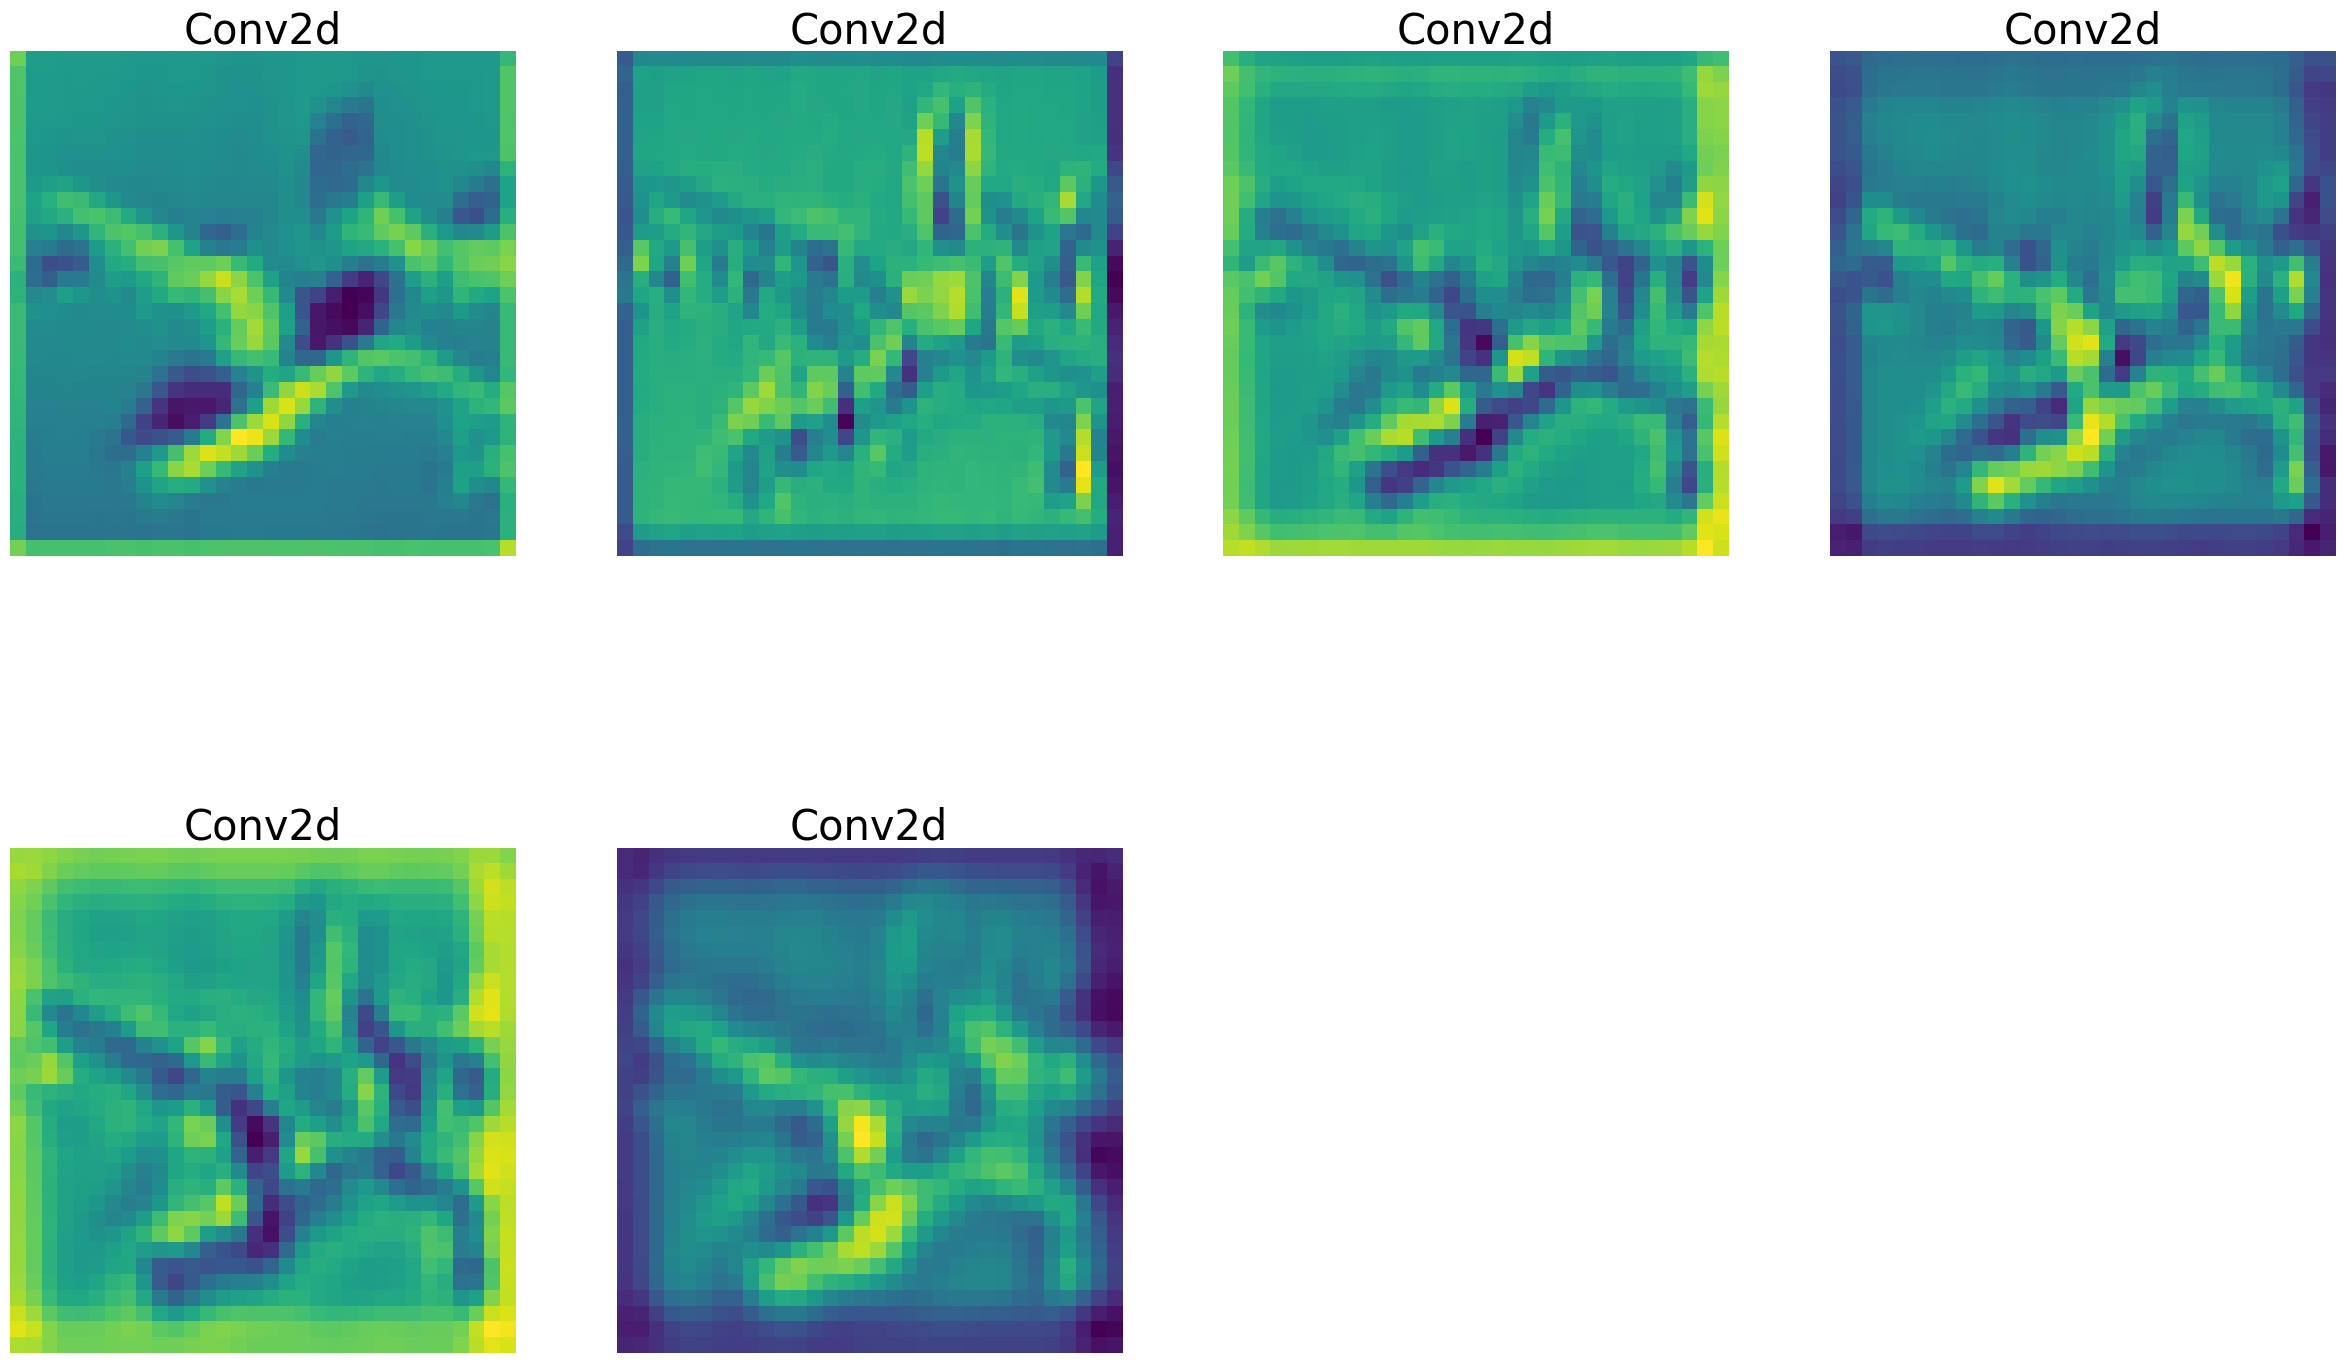

In [ ]:

processed = []
for featureMap in outputs:
    featureMap = featureMap.squeeze(0)
    grayScale = torch.sum(featureMap,0)
    grayScale = grayScale / featureMap.shape[0]
    processed.append(grayScale.data.cpu().numpy())


fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')
